In [117]:
pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
import json 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pickle
import colorama 
from colorama import Fore, Style, Back
import random

In [219]:
with open('intents.json') as file:
    data = json.load(file)
    
training_sentences = []
training_labels = []
labels = []
responses = []


for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])
    
    if intent['tag'] not in labels:
        labels.append(intent['tag'])
        
num_classes = len(labels)

In [200]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 12.5 MB/s eta 0:00:00


In [216]:
import nlpaug.augmenter.word as naw

# List of training sentences
sentences = ['I like cats', 'The dog barked', 'She ate the cake']

# Initialize augmentation object
aug = naw.SynonymAug(aug_src='wordnet')

# Augment sentences
aug_sentences = []
for sentence in training_sentences:
    aug_sentence = aug.augment(sentence)
    aug_sentences.append(aug_sentence)
    
# Print augmented sentences
print(aug_sentences)

training_sentences.extend(aug_sentences)

print(len(training_sentences))

[["Hawai'i"], ['Hey'], ['Comprise anyone at that place?'], ['Hello there'], ['Howdy'], ['Hey on that point'], ['How do you do'], ['Hola'], ['Bonjour'], ['Konnichiwa'], ['Guten tag'], ['Olla'], ['Good good morning'], ['Honest afternoon'], ['Just evening'], ['Good nighttime'], ['Au revoir'], ['See you later'], ['Adieu'], ['Au revoir'], ['Adieu'], ['ok good bye'], ['Adios then'], ['Fare thee well'], ['Thanks'], ['Thank you'], ["That ' s helpful"], ['Thanks for the assistance'], ['Than you very a great deal'], [], ['nil much'], ['Who be you?'], ['What be you?'], ['Who you exist?'], ['Tell pine tree state more astir yourself.'], ['What be your name?'], ['What should I prognosticate you?'], ["What ' s your name?"], ['Severalise me about yourself'], ['What can you do?'], ['Who create you?'], ['How make up you hit?'], ['How be you create?'], ['My epithet is'], ['Ace exist name.'], ['Iodine go by'], ['Could you help pine tree state?'], ['break maine a hand please'], ['Dismiss you help?'], ['Wha

In [221]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

In [222]:
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

##CHATGPT MODEL

In [208]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Concatenate, Dot, Activation, Flatten, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

In [223]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_77 (Embedding)    (None, 20, 16)            16000     
                                                                 
 bidirectional_136 (Bidirect  (None, 20, 32)           4224      
 ional)                                                          
                                                                 
 dropout_22 (Dropout)        (None, 20, 32)            0         
                                                                 
 bidirectional_137 (Bidirect  (None, 20, 32)           6272      
 ional)                                                          
                                                                 
 flatten_33 (Flatten)        (None, 640)               0         
                                                                 
 dense_99 (Dense)            (None, 80)              

In [210]:
from keras.utils import to_categorical

one_hot_labels = to_categorical(training_labels, num_classes)

In [225]:
epochs = 50
history = model.fit(padded_sequences, training_labels, epochs=epochs, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/50
7/7 [==============================] - 0s 45ms/step - loss: 3.4517 - accuracy: 0.0817 - val_loss: 6.4553 - val_accuracy: 0.0000e+00
Epoch 2/50
7/7 [==============================] - 0s 48ms/step - loss: 3.3616 - accuracy: 0.0625 - val_loss: 6.9034 - val_accuracy: 0.0000e+00
Epoch 3/50
7/7 [==============================] - 0s 47ms/step - loss: 3.2215 - accuracy: 0.1202 - val_loss: 7.9135 - val_accuracy: 0.0000e+00
Epoch 4/50
7/7 [==============================] - 0s 46ms/step - loss: 3.0938 - accuracy: 0.1346 - val_loss: 8.7998 - val_accuracy: 0.0000e+00
Epoch 5/50
7/7 [==============================] - 0s 46ms/step - loss: 2.9646 - accuracy: 0.1635 - val_loss: 9.7523 - val_accuracy: 0.0000e+00
Epoch 6/50
7/7 [==============================] - 0s 47ms/step - loss: 2.8824 - accuracy: 0.1779 - val_loss: 10.4858 - val_accuracy: 0.0000e+00
Epoch 7/50
7/7 [==============================] - 0s 46ms/step - loss: 2.7844 - accuracy: 0.1587 - val_loss: 11.0395 - val_accuracy: 0.0000e+

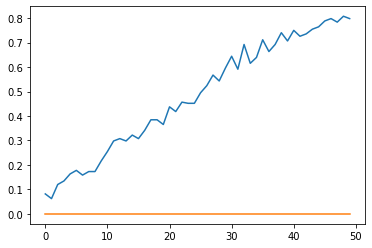

In [228]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

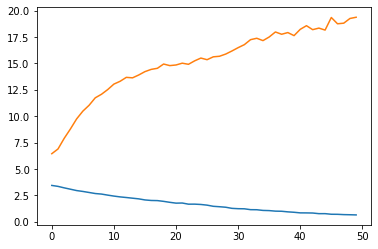

In [226]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [176]:
# to save the trained model
model.save("chat_model")

# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

In [177]:
with open("intents.json") as file:
    data = json.load(file)


def chat():
    # load trained model
    model = keras.models.load_model('chat_model')

    # load tokenizer object
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    # parameters
    max_len = 20
    
    while True:
        print(Fore.LIGHTBLUE_EX + "User: " + Style.RESET_ALL, end="")
        inp = input()
        if inp.lower() == "quit":
            break

        result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len))
        #print(result)                                    
        tag = lbl_encoder.inverse_transform([np.argmax(result)])
        print(tag)
        for i in data['intents']:
            if i['tag'] == tag:
                print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))

        # print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL,random.choice(responses))

print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)
chat()

Start messaging with the bot (type quit to stop)!
User: hello
1/1 [==============================] - 2s 2s/step
['greeting']
ChatBot: Great to see you. How do you feel currently?
User: whats up
1/1 [==============================] - 0s 31ms/step
['stupid']
ChatBot: I wish you wouldn't say such hurtful things. I'm sorry if I wasn't useful
User: youre gay
1/1 [==============================] - 0s 28ms/step
['thanks']
ChatBot: You're most welcome!
User: faggot
1/1 [==============================] - 0s 28ms/step
['default']
ChatBot: I see. What else?
User: im sad
1/1 [==============================] - 0s 45ms/step
['casual']
ChatBot: How were you feeling last week?
User: i am unhappy
1/1 [==============================] - 0s 28ms/step
['name']
ChatBot: That's a great name. Tell me more about yourself.
User: quit
